Mounted at /content/drive
Found 7000 files belonging to 2 classes.
Found 1500 files belonging to 2 classes.
Found 1500 files belonging to 2 classes.
Extracting features...


Extracting: 100%|██████████| 47/47 [02:47<00:00,  3.57s/it]

Shapes → Train: (7000, 1774), Val: (1500, 1774), Test: (1500, 1774)

Building pipeline with GridSearchCV...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


Best C: 0.1
Best CV Score: 0.7371447849141871

FINAL ACCURACY (NO OVERFIT)
Training:     0.7883
Validation:   0.7607
Testing:      0.7613


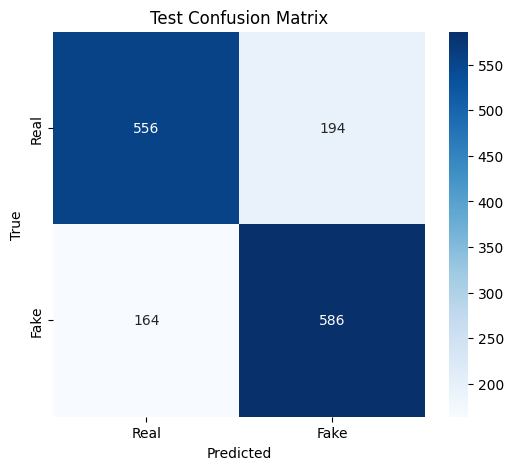

              precision    recall  f1-score   support

        Real       0.77      0.74      0.76       750
        Fake       0.75      0.78      0.77       750

    accuracy                           0.76      1500
   macro avg       0.76      0.76      0.76      1500
weighted avg       0.76      0.76      0.76      1500



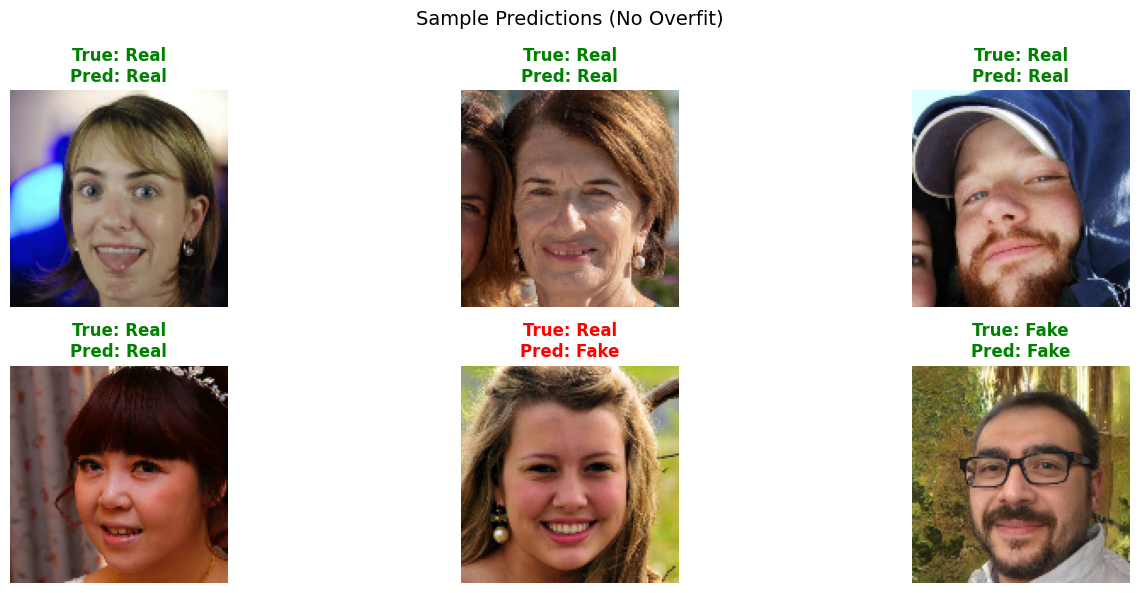


FINAL STABLE RESULTS
Training Accuracy:     0.7883
Validation Accuracy:   0.7607
Testing Accuracy:      0.7613


In [ ]:
# ====================================================
# DEEPFAKE DETECTION: LINEAR SVM + PCA + SCALING
# ====================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog, local_binary_pattern
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from google.colab import drive
from tqdm import tqdm
import cv2

# Mount Drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/deepfakeDataset'
train_dir = f"{BASE_PATH}/train"
test_dir  = f"{BASE_PATH}/test"
val_dir   = f"{BASE_PATH}/validate"

# Parameters
IMG_SIZE = (128, 128)
HOG_PPC = (16, 16)
HOG_CPB = (2, 2)
LBP_POINTS = 8
LBP_RADIUS = 1
SEED = 42

# Load datasets
def load_ds(path):
    return image_dataset_from_directory(
        path, image_size=IMG_SIZE, batch_size=32,
        label_mode='binary', shuffle=False, seed=SEED
    )

train_ds = load_ds(train_dir)
test_ds  = load_ds(test_dir)
val_ds   = load_ds(val_dir)

# Feature Extraction
def extract_hog_lbp(img_batch):
    imgs = img_batch.numpy().astype(np.uint8)
    feats = []
    for img in imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # HOG
        h = hog(gray, orientations=9, pixels_per_cell=HOG_PPC,
                cells_per_block=HOG_CPB, block_norm='L2-Hys', feature_vector=True)
        # LBP
        lbp = local_binary_pattern(gray, P=LBP_POINTS, R=LBP_RADIUS, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3),
                               range=(0, LBP_POINTS + 2))
        hist = hist.astype(float)
        hist /= (hist.sum() + 1e-7)
        feats.append(np.hstack([h, hist]))
    return np.array(feats)

def ds_to_features(ds):
    X, y = [], []
    for img, lab in tqdm(ds, desc="Extracting"):
        X.append(extract_hog_lbp(img))
        y.extend(lab.numpy().flatten())
    return np.vstack(X), np.array(y)

print("Extracting features...")
X_train, y_train = ds_to_features(train_ds)
X_val,   y_val   = ds_to_features(val_ds)
X_test,  y_test  = ds_to_features(test_ds)

print(f"Shapes → Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ==========================================
# FINAL PIPELINE: Scaling + PCA + LinearSVC
# ==========================================
print("\nBuilding pipeline with GridSearchCV...")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=SEED)),  # Keep 95% variance
    ('svm', svm.LinearSVC(random_state=SEED, max_iter=10000))
])

param_grid = {
    'svm__C': [0.1, 1, 10],
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best C:", grid.best_params_['svm__C'])
print("Best CV Score:", grid.best_score_)

# Final Model
best_model = grid.best_estimator_

# Predict
y_train_pred = best_model.predict(X_train)
y_val_pred   = best_model.predict(X_val)
y_test_pred  = best_model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
val_acc   = accuracy_score(y_val, y_val_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

print("\n" + "="*50)
print("FINAL ACCURACY (NO OVERFIT)")
print("="*50)
print(f"Training:     {train_acc:.4f}")
print(f"Validation:   {val_acc:.4f}")
print(f"Testing:      {test_acc:.4f}")
print("="*50)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test, y_test_pred, target_names=['Real', 'Fake']))

# Sample Predictions
def get_samples(ds, X, y_true, y_pred, n=6):
    imgs, t, p = [], [], []
    idx = np.random.choice(len(y_true), n, replace=False)
    count = 0
    for img_b, lab_b in ds:
        start, end = count, count + len(img_b)
        for i in idx:
            if start <= i < end:
                local = i - start
                imgs.append(img_b[local].numpy())
                t.append(int(y_true[i]))
                p.append(int(y_pred[i]))
        count = end
        if len(imgs) >= n: break
    return imgs, t, p

sample_imgs, true_l, pred_l = get_samples(test_ds, X_test, y_test, y_test_pred)

plt.figure(figsize=(15,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(sample_imgs[i].astype('uint8'))
    color = 'green' if true_l[i] == pred_l[i] else 'red'
    plt.title(f"True: {'Fake' if true_l[i] else 'Real'}\nPred: {'Fake' if pred_l[i] else 'Real'}",
              color=color, fontweight='bold')
    plt.axis('off')
plt.suptitle("Sample Predictions (No Overfit)", fontsize=14)
plt.tight_layout()
plt.show()

# FINAL PRINT
print("\n" + "="*60)
print("FINAL STABLE RESULTS")
print("="*60)
print(f"Training Accuracy:     {train_acc:.4f}")
print(f"Validation Accuracy:   {val_acc:.4f}")
print(f"Testing Accuracy:      {test_acc:.4f}")
print("="*60)